In [ ]:
import os
import sys
import pathlib
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## load the files
ks_dir = r"Z:\Koji\9153_01292025_tagging_g0\9153_01292025_tagging_g0_imec0\kilosort4"

DLC = pd.read_hdf(r"Z:\Koji\DLC\9153\9153_Day5_4rewards2025-01-29DLC_HrnetW32_Neuropixel_9153Jun23shuffle1_detector_230_snapshot_210_filtered.h5")
snout_x = DLC.iloc[:, DLC.columns.get_loc(('DLC_HrnetW32_Neuropixel_9153Jun23shuffle1_detector_230_snapshot_210', 'Snout', 'x'))].values
snout_y = DLC.iloc[:, DLC.columns.get_loc(('DLC_HrnetW32_Neuropixel_9153Jun23shuffle1_detector_230_snapshot_210', 'Snout', 'y'))].values
tail_x = DLC.iloc[:, DLC.columns.get_loc(('DLC_HrnetW32_Neuropixel_9153Jun23shuffle1_detector_230_snapshot_210', 'Tail', 'x'))].values
tail_y = DLC.iloc[:, DLC.columns.get_loc(('DLC_HrnetW32_Neuropixel_9153Jun23shuffle1_detector_230_snapshot_210', 'Tail', 'y'))].values
# Average position
avg_x = (snout_x + tail_x) / 2+
avg_y = (snout_y + tail_y) / 2
# Compute speed (Euclidean distance between consecutive frames)
dx = np.diff(avg_x)
dy = np.diff(avg_y)
speed = np.sqrt(dx**2 + dy**2)

# Pad with zero to match original length
speed = np.concatenate([[0], speed])
celltype = pd.read_csv(r"Z:\Koji\9153_01292025_tagging_g0\9153_01292025_tagging_g0_imec0\kilosort4\unit_classification_rulebased.csv")
tagged_unit = np.load(r"Z:\Koji\9153_01292025_tagging_g0\9153_01292025_tagging_g0_imec0\kilosort4\tagged_units_final.npy")
spike_clusters = np.load(r"Z:\Koji\9153_01292025_tagging_g0\9153_01292025_tagging_g0_imec0\kilosort4\spike_clusters.npy")
spike_seconds = np.load(r"Z:\Koji\9153_01292025_tagging_g0\9153_01292025_tagging_g0_imec0\kilosort4\spike_seconds_adj.npy")
spike_positions = np.load(r"Z:\Koji\9153_01292025_tagging_g0\9153_01292025_tagging_g0_imec0\kilosort4\spike_positions.npy")
strobe_seconds = np.load(r"Z:\Koji\9153_01292025_tagging_g0\9153_01292025_tagging_g0_imec0\kilosort4\strobe_seconds.npy")
tagged_good_unit = np.load(r"Z:\Koji\9153_01292025_tagging_g0\9153_01292025_tagging_g0_imec0\kilosort4\tagged_good_units.npy")
tagged_mua_unit = np.load(r"Z:\Koji\9153_01292025_tagging_g0\9153_01292025_tagging_g0_imec0\kilosort4\tagged_mua_units.npy")
print("tagged_unit (original)        =", len(tagged_good_unit)+len(tagged_mua_unit))

start = strobe_seconds[0]
end = strobe_seconds[-1]

# Create a mask based on the original spike_seconds
mask = (spike_seconds >= start) & (spike_seconds <= end)
spike_seconds = spike_seconds[mask]
spike_clusters = spike_clusters[mask]
spike_positions = spike_positions[mask]

# Select MSN units
non_tagged_msn = celltype.loc[celltype['cell_type'] == 'MSN', 'unit_id'].values
non_tagged_msn = non_tagged_msn[~np.isin(non_tagged_msn, tagged_unit)]

print("tagged_unit (waveform filter) =", len(tagged_unit), ", non_tagged_msn             =", len(non_tagged_msn))

# Eliminate the unit from both tagged and non-tagged lists which FR is less than 0.2 or more than 15
spike_clusters_counts = np.bincount(spike_clusters)
unit_mask = non_tagged_msn < len(spike_clusters_counts)
unit_counts = np.zeros_like(non_tagged_msn, dtype=float)
unit_counts[unit_mask] = spike_clusters_counts[non_tagged_msn[unit_mask]]
FR = unit_counts / (end - start)
non_tagged_msn = non_tagged_msn[(FR >= 0.5) & (FR <= 6)]

spike_clusters_counts = np.bincount(spike_clusters)
unit_mask = tagged_unit < len(spike_clusters_counts)
unit_counts = np.zeros_like(tagged_unit, dtype=float)
unit_counts[unit_mask] = spike_clusters_counts[tagged_unit[unit_mask]]
FR = unit_counts / (end - start)
tagged_unit = tagged_unit[(FR >= 0.5) & (FR <= 6)]

print("tagged_unit (FR filter)       =", len(tagged_unit), ", non_tagged_msn (FR filter) =", len(non_tagged_msn))

tagged_unit (original)        = 32
tagged_unit (waveform filter) = 24 , non_tagged_msn             = 295
tagged_unit (FR filter)       = 17 , non_tagged_msn (FR filter) = 173


In [79]:
from ipywidgets import interact, IntSlider

import matplotlib.pyplot as plt

def plot_speed_scrollable(start_idx=0, window=1000):
    plt.figure(figsize=(15, 4))
    idx_end = min(start_idx + window, len(speed))
    plt.plot(np.arange(start_idx, idx_end), speed[start_idx:idx_end])
    plt.xlabel('Frame')
    plt.ylabel('Speed')
    plt.title(f'Speed (frames {start_idx} to {idx_end})')
    plt.tight_layout()
    plt.show()

interact(plot_speed_scrollable,
         start_idx=IntSlider(min=0, max=len(speed)-1000, step=100, value=0, description='Start Frame'),
         window=IntSlider(min=100, max=10000, step=100, value=1000, description='Window Size'))

interactive(children=(IntSlider(value=0, description='Start Frame', max=166543, step=100), IntSlider(value=100…

<function __main__.plot_speed_scrollable(start_idx=0, window=1000)>

In [ ]:
# import numpy as np
# import scipy.io as sio

# # Use your filtered list of units (e.g., all_units = np.concatenate([tagged_unit, non_tagged_msn]))
# all_units = np.concatenate([tagged_unit, non_tagged_msn])
# BIN_SIZE = 0.025  # 5 ms
# start, end = strobe_seconds[0], strobe_seconds[-1]
# n_bins = int(np.ceil((end - start) / BIN_SIZE))

# unit_id_map = {uid: i for i, uid in enumerate(all_units)}
# X = np.zeros((len(all_units), n_bins))

# for spike_time, cluster in zip(spike_seconds, spike_clusters):
#     if cluster in unit_id_map:
#         bin_idx = int((spike_time - start) / BIN_SIZE)
#         if 0 <= bin_idx < n_bins:
#             X[unit_id_map[cluster], bin_idx] += 1

# # Save to .mat for MATLAB
# sio.savemat(os.path.join(ks_dir, 'binned_spikes.mat'), {'X': X})

In [ ]:
import numpy as np
import scipy.io as sio
import os
from scipy.ndimage import label

BIN_SIZE = 0.025
speed_threshold = 5.0
min_duration_sec = 0.3
sampling_rate = 89.97  # frames per second
min_bins = int(np.ceil(min_duration_sec / BIN_SIZE))  # Minimum bins for 0.2s

start_time = strobe_seconds[0]
end_time = strobe_seconds[-1]
n_bins = int(np.ceil((end_time - start_time) / BIN_SIZE))

all_units = np.concatenate([tagged_unit, non_tagged_msn])
unit_id_map = {uid: i for i, uid in enumerate(all_units)}

# Bin all spikes for the entire session
X_full = np.zeros((len(all_units), n_bins))
for spike_time, cluster in zip(spike_seconds, spike_clusters):
    if cluster in unit_id_map:
        bin_idx = int((spike_time - start_time) / BIN_SIZE)
        if 0 <= bin_idx < n_bins:
            X_full[unit_id_map[cluster], bin_idx] += 1

# Build the running mask for all bins
speed = np.asarray(speed)
running_mask = (speed > speed_threshold)

# Label contiguous running segments
labeled, num_features = label(running_mask)
final_running_mask = np.zeros_like(running_mask, dtype=bool)
for i in range(1, num_features + 1):
    idx = np.where(labeled == i)[0]
    if len(idx) >= min_bins:
        final_running_mask[idx] = True

# Adjust mask length if needed
if len(final_running_mask) > n_bins:
    final_running_mask = final_running_mask[:n_bins]
elif len(final_running_mask) < n_bins:
    final_running_mask = np.pad(final_running_mask, (0, n_bins - len(final_running_mask)), 'constant', constant_values=False)

# Mask out non-running bins
X_masked = X_full.copy()
X_masked[:, ~final_running_mask] = 0

# Save for MATLAB
sio.savemat(os.path.join(ks_dir, 'binned_spikes_masked.mat'), {'X': X_masked, 'running_mask': final_running_mask})

n_neurons, n_bins = X_masked.shape

# Find spikes (indices) during running
spike_neuron, spike_bin = np.nonzero(X_masked)
spike_times = spike_bin * BIN_SIZE  # Convert bin to seconds

from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt
import numpy as np

# Assume X_masked is (n_neurons, n_bins)
# Assume BIN_SIZE is defined

def plot_spike_raster_scrollable(start_bin=0, window=1000):
    end_bin = min(start_bin + window, X_masked.shape[1])
    X_slice = X_masked[:, start_bin:end_bin]

    # Get (neuron, bin) indices for spikes in the window
    neuron_idx, bin_idx = np.nonzero(X_slice)
    times = (start_bin + bin_idx) * BIN_SIZE

    plt.figure(figsize=(15, 6))
    plt.scatter(times, neuron_idx, s=2, color='k', marker='|', alpha=0.6)
    plt.xlabel('Time (s)')
    plt.ylabel('Neuron #')
    plt.title(f'Spike Raster: bins {start_bin} to {end_bin}')
    plt.ylim(-1, X_masked.shape[0])
    plt.xlim((start_bin*BIN_SIZE, end_bin*BIN_SIZE))
    plt.tight_layout()
    plt.show()

max_bin = X_masked.shape[1]
interact(plot_spike_raster_scrollable,
         start_bin=IntSlider(min=0, max=max_bin-1000, step=100, value=0, description='Start Bin'),
         window=IntSlider(min=100, max=10000, step=100, value=1000, description='Window Size'))


interactive(children=(IntSlider(value=0, description='Start Bin', max=73357, step=100), IntSlider(value=1000, …

<function __main__.plot_spike_raster_scrollable(start_bin=0, window=1000)>

* Run seqNMF_analysis.mat (in chunky)  
* Then, proceed to the next code cell.

In [84]:
!matlab -batch "K=5; L=40; lambda=0; run('seqnmf_analysis.m')"

In [85]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

# Path to your results file
result_path = r"Z:\Koji\9153_01292025_tagging_g0\9153_01292025_tagging_g0_imec0\kilosort4\seqNMF_results.mat"

# Load the .mat file

data = sio.loadmat(result_path)

# MATLAB fields are often wrapped in extra arrays; extract them:
W = data['W']        # shape: (n_units, L, K)
H = data['H']        # shape: (K, n_bins)
cost = data['cost']  # sometimes shape (1, N)
loadings = data.get('loadings')  # optional, if saved
power = data.get('power')        # optional, if saved

print(f"W shape: {W.shape}, H shape: {H.shape}")

W shape: (190, 5, 40), H shape: (5, 74357)


Text(0.5, 1.0, 'Cost Function Over Iterations')

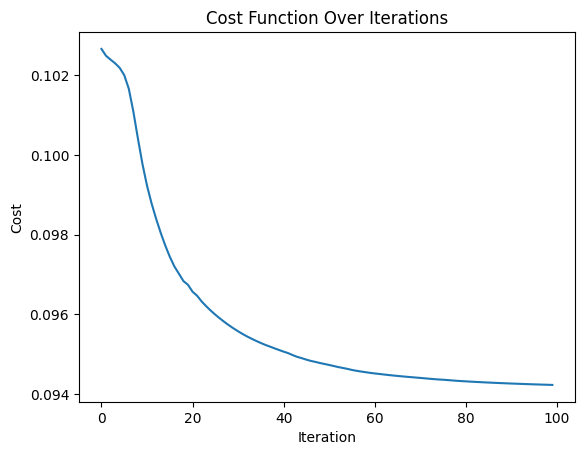

In [86]:
plt.plot(cost[1:])
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost Function Over Iterations')

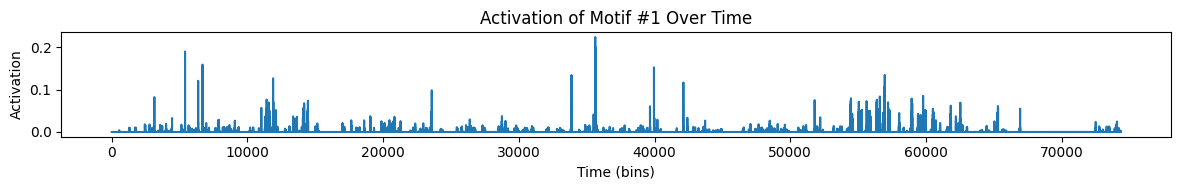

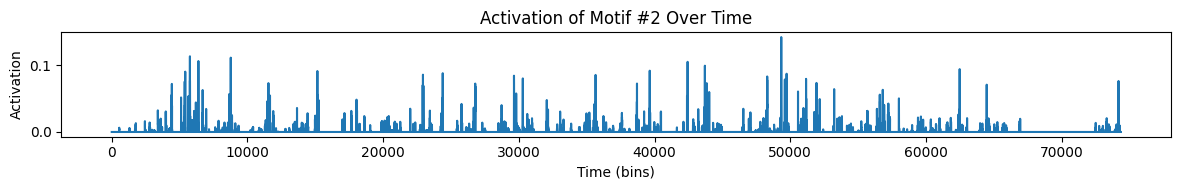

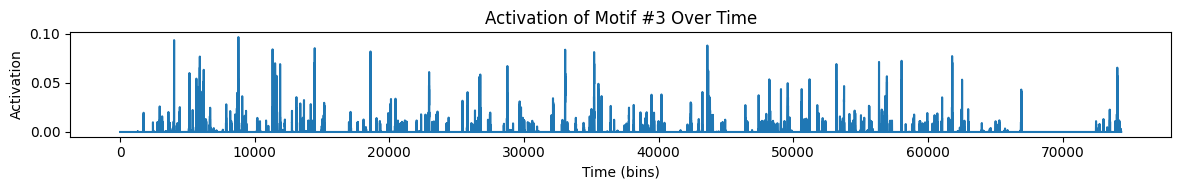

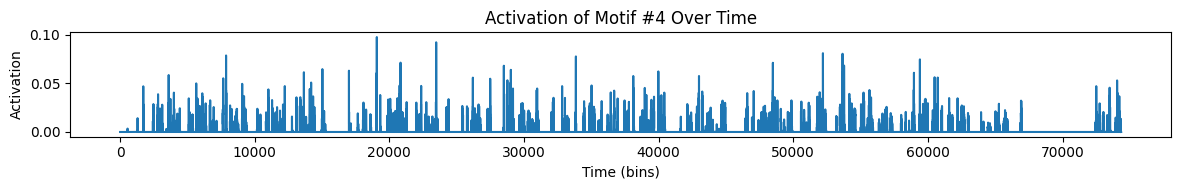

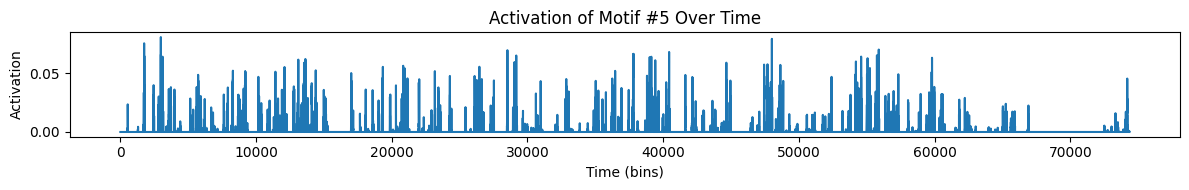

In [87]:
K = H.shape[0]
for k in range(K):
    plt.figure(figsize=(12, 2))
    plt.plot(H[k, :])
    plt.title(f'Activation of Motif #{k+1} Over Time')
    plt.xlabel('Time (bins)')
    plt.ylabel('Activation')
    plt.tight_layout()
    plt.show()


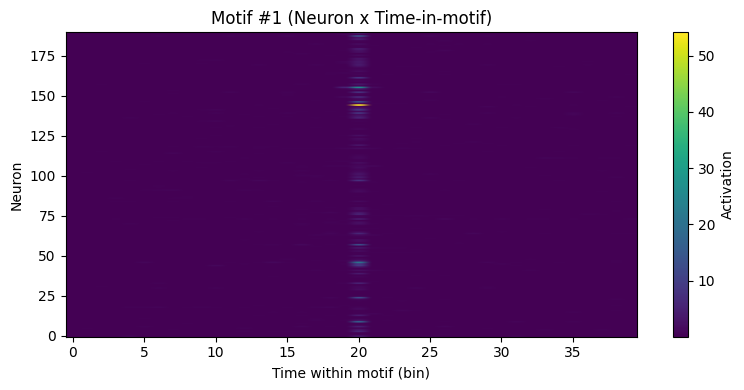

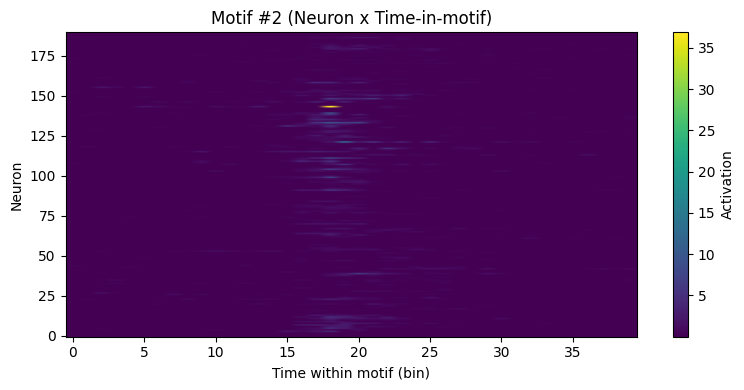

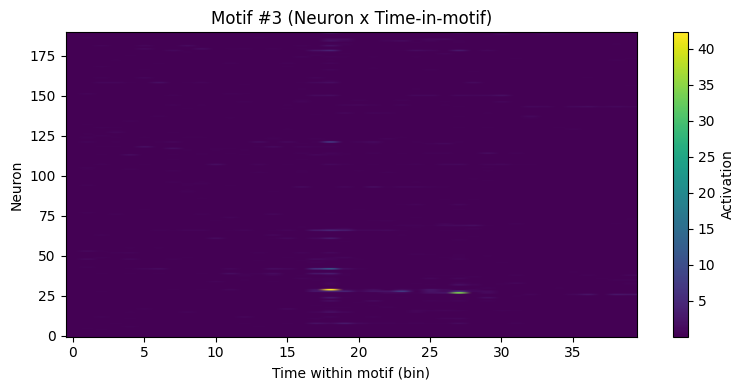

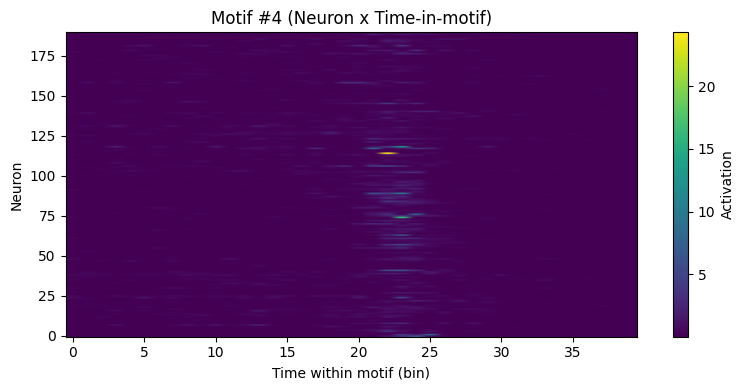

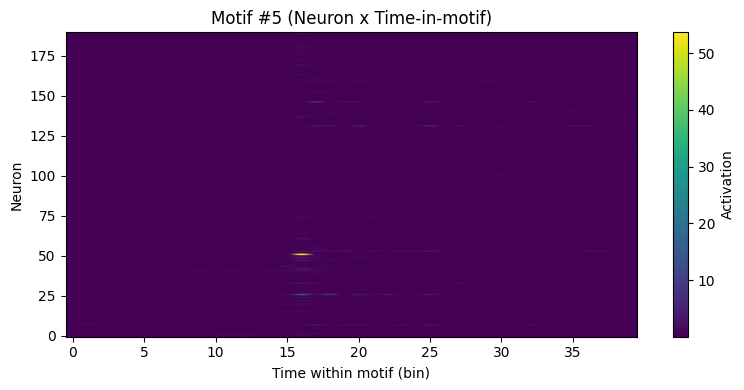

In [88]:
n_neurons, K, L = W.shape
for k in range(K):
    plt.figure(figsize=(8, 4))
    plt.imshow(W[:, k, :], aspect='auto', origin='lower')
    plt.title(f'Motif #{k+1} (Neuron x Time-in-motif)')
    plt.xlabel('Time within motif (bin)')
    plt.ylabel('Neuron')
    plt.colorbar(label='Activation')
    plt.tight_layout()
    plt.show()



In [89]:
if loadings is not None:
    print("Loadings shape:", loadings.shape)
    # Analyze as needed

if power is not None:
    print("Power shape:", power.shape)
    # Analyze as needed


Loadings shape: (1, 5)
Power shape: (1, 1)
